In [1]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import tensorflow as tf
# from keras import layers


from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing import image

import tensorflow.keras.backend as K


from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random



In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) == 0:
    print("Not enough GPU hardware devices available")
else:
    config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  1


2023-06-04 19:53:21.951363: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-06-04 19:53:21.985954: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-04 19:53:21.986364: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 with Max-Q Design computeCapability: 7.5
coreClock: 1.23GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 357.69GiB/s
2023-06-04 19:53:21.986595: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-06-04 19:53:21.988154: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-06-04 19:53:21.989680: I tensorflow/st

In [3]:
# tf.debugging.set_log_device_placement(True)       # Will print the log information of every execution of tensorflow, mainly about 

In [4]:
#Size of our input images
# SIZE = 128        # It was this value at the beginning, but the image display was poor. 
SIZE = 224
# SIZE = 228          # It was 224, but in order for the current autoencoder model configuration work adequately, we changed it 228

# Setting the training and testing datasets 

ImageDataGenerator.flow_from_directory: Takes the path to a directory and generates batches of augmented data.

In [5]:
batch_size = 15

# Data augmentation generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # zoom_range=0.2,
    brightness_range=[0.88,1.0],
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # rotation_range=20)
    # zoom_range=0.2,
    horizontal_flip=True)

# Original images generator
original_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    "../../Images/BottleStoodUp_atNight/Positive/",     # For home laptop
    # "../../../BottleStoodUp_atNight/Positive/",           # For work laptop
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    shuffle = False,
    class_mode='input'          # Class used for working with Autoencoders
    
    )

# Generate original images from the original data directory
original_generator = original_datagen.flow_from_directory(
    "../../Images/BottleStoodUp_atNight/Positive/",
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    shuffle = False,
    class_mode='input')

# Combine the generators using the `keras.preprocessing.image.Iterator` class
combined_generator = zip(train_generator, original_generator)

Found 179 images belonging to 1 classes.
Found 179 images belonging to 1 classes.


In [6]:
validation_generator = original_datagen.flow_from_directory(
    "../../Images/BottleStoodUp_atNight/Positive_val/",     # For home laptop
    # "../../../BottleStoodUp_atNight/Positive_val/",           # For work lpatop   
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    shuffle = False,
    class_mode='input'
    )


Found 30 images belonging to 1 classes.


In [7]:
anomaly_generator = original_datagen.flow_from_directory(
    "../../Images/BottleStoodUp_atNight/Anomalies2.0/",         # For home laptop
    # "../../../BottleStoodUp_atNight/Anomalies2.0/",           # For work lpatpo
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    shuffle = False,
    class_mode='input'
    )


Found 6 images belonging to 1 classes.


In [8]:
test_set_generator = original_datagen.flow_from_directory(
    "../../Images/BottleStoodUp_atNight/Evaluation/",       # For home laptop
    # "../../../BottleStoodUp_atNight/Evaluation/",             # For work laptop  
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    shuffle = False,
    class_mode='binary'
    )


Found 30 images belonging to 2 classes.


# Showing one sample of the training set images

Grabbing only one image of one batch of the training set.

In [9]:
(augmented_images_batch, original_images_batch) = next(combined_generator)
print("FOR THE AUGMENTED IMAGES")
print(type(augmented_images_batch))
print(len(augmented_images_batch))
print(tf.reduce_min(augmented_images_batch), tf.reduce_max(augmented_images_batch))
print("FOR THE ORIGINAL IMAGES")
print(type(original_images_batch))
print(len(original_images_batch))
print(tf.reduce_min(original_images_batch), tf.reduce_max(original_images_batch))



FOR THE AUGMENTED IMAGES
<class 'tuple'>
2


2023-06-04 19:53:22.575898: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2023-06-04 19:53:22.579698: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2599990000 Hz
2023-06-04 19:53:22.580056: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2f040012d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-06-04 19:53:22.580069: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-06-04 19:53:22.645115: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-04 19:53:22.645564: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3a45900 initialized for platform CUDA (this does not guarantee that XLA will

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.98823535, shape=(), dtype=float32)
FOR THE ORIGINAL IMAGES
<class 'tuple'>
2
tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


One sample of the augmented images
2
(15, 224, 224, 3)


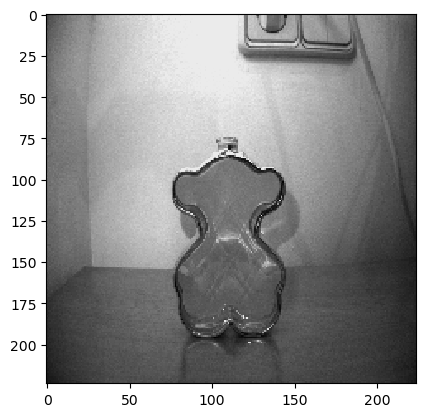

In [10]:
print("One sample of the augmented images")
print(len(augmented_images_batch))
input_batch_augmented = augmented_images_batch[0]
print(input_batch_augmented.shape)
single_img = input_batch_augmented[0]
plt.imshow(single_img)

One sample of the original images
2
(15, 224, 224, 3)


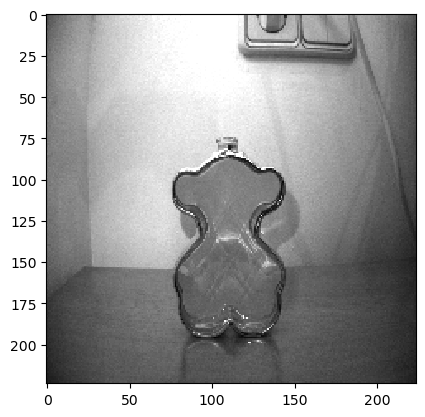

In [11]:
print("One sample of the original images")
print(len(original_images_batch))
input_batch_original = original_images_batch[0]
print(input_batch_original.shape)
single_img_orgn = input_batch_original[0]
plt.imshow(single_img_orgn)

# Configuring the Autoencoder netwrok

In [12]:
latent_dim = 32  # Number of latent dimension parameters

input_img = Input(shape=(SIZE, SIZE, 3))
x = Conv2D(128, (3, 3), activation='relu', padding='same') (input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)


x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPool2D( (2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPool2D( (2, 2), padding='same')(x)

x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = MaxPool2D( (2, 2), padding='same')(x)

x = Conv2D(1, (3, 3), activation='relu', padding='same')(x)

shape_before_flattening = K.int_shape(x)
print(shape_before_flattening)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)

Z = Dense(latent_dim)(x)
print(K.int_shape(Z))

encoder = Model(input_img,Z)
encoder.summary()

(None, 7, 7, 1)
(None, 32)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None

In [13]:
# decoder takes the latent distribution sample as input
decoder_input = Input(K.int_shape(Z)[1:])
x = Dense(14*14*4, activation='relu', name="intermediate_decoder", input_shape=(latent_dim,))(decoder_input)
# Expand to 784 total pixels
x = Dense(784, activation='sigmoid', name="original_decoder")(x)
x = Reshape((14,14,4),input_shape=(784,))(x)

x = Conv2DTranspose(3, (3, 3), padding='same')(x)
x = UpSampling2D( (2, 2))(x)

x = Conv2DTranspose(3, (3, 3), padding='same')(x)
x = UpSampling2D( (2, 2))(x)

x = Conv2DTranspose(3, (3, 3), padding='same')(x)
x = UpSampling2D( (2, 2))(x)

x = Conv2DTranspose(3, (3, 3), padding='same')(x)
x = UpSampling2D( (2, 2))(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(Z)

decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
intermediate_decoder (Dense) (None, 784)               25872     
_________________________________________________________________
original_decoder (Dense)     (None, 784)               615440    
_________________________________________________________________
reshape (Reshape)            (None, 14, 14, 4)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 3)         111       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 28, 28, 3)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 3)         84  

In [14]:
# VAE model statement
ae = Model(input_img,z_decoded)
ae.compile(optimizer='adam', loss='binary_crossentropy')

ae.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 32)        0   

These are the weights of a specific layer of the encoder model, before training are:

In [15]:
layer_number = 1
print("quantity of layers in the model: ", len(encoder.layers))
print("The weigths in the", encoder.layers[layer_number].name, "is: ", encoder.layers[layer_number].weights)

quantity of layers in the model:  15
The weigths in the conv2d is:  [<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 128) dtype=float32, numpy=
array([[[[-3.38533521e-03,  2.96345949e-02,  5.27270734e-02, ...,
          -6.96150810e-02, -5.41122630e-02,  2.46541202e-03],
         [-5.62018901e-02, -1.30046196e-02, -2.60978192e-02, ...,
          -3.06104049e-02, -1.48366950e-02, -4.22183424e-03],
         [-5.87034412e-02,  2.57468373e-02, -2.69534364e-02, ...,
          -6.20585531e-02, -5.90259023e-02,  1.04921162e-02]],

        [[ 3.38613391e-02, -4.85997796e-02, -5.43352216e-02, ...,
          -3.95032205e-02, -4.86467704e-02, -3.38061303e-02],
         [ 5.52087575e-02,  1.16422772e-04,  4.46298048e-02, ...,
           5.89570999e-02, -3.45966890e-02, -2.10162736e-02],
         [ 2.36154199e-02, -6.59161359e-02, -5.91775961e-02, ...,
          -2.85960212e-02,  5.06233796e-02,  3.85369658e-02]],

        [[-5.42465746e-02,  2.11755410e-02,  4.61248606e-02, ...,
          -3.786531

These are the weights of a specific layer of the decoder model,before training are:

In [ ]:
# layer_number = 1
# print("quantity of layers in the model: ", len(decoder.layers))
# print("The weigths in the", decoder.layers[layer_number].name, "is: ", decoder.layers[layer_number].weights)

These are the weights of a specific layer of the autoencoder model,before training are:

In [ ]:
# layer_number = 1
# print("quantity of layers in the model: ", len(ae.layers))
# print("The weigths in the", ae.layers[layer_number].name, "is: ", ae.layers[layer_number].weights)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
# run the model
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=5, mode='auto')
history = ae.fit(combined_generator, epochs=2000, validation_data=validation_generator, callbacks=[early_stopping],verbose=1, steps_per_epoch=(len(original_generator)*20))

Epoch 1/2000


2023-06-04 19:54:08.002575: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-06-04 19:54:08.225963: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


240/240 [==============================] - 35s 145ms/step - loss: 1.5794 - val_loss: 0.6651
Epoch 2/2000
240/240 [==============================] - 34s 141ms/step - loss: 0.6565 - val_loss: 0.6449
Epoch 3/2000
240/240 [==============================] - 33s 137ms/step - loss: 0.6301 - val_loss: 0.6262
Epoch 4/2000
240/240 [==============================] - 33s 140ms/step - loss: 0.6248 - val_loss: 0.6250
Epoch 5/2000
240/240 [==============================] - 33s 139ms/step - loss: 0.6228 - val_loss: 0.6235
Epoch 6/2000
240/240 [==============================] - 34s 143ms/step - loss: 0.6218 - val_loss: 0.6218
Epoch 7/2000
240/240 [==============================] - 34s 141ms/step - loss: 0.6197 - val_loss: 0.6216
Epoch 8/2000
240/240 [==============================] - 34s 142ms/step - loss: 0.6184 - val_loss: 0.6211
Epoch 9/2000
240/240 [==============================] - 34s 143ms/step - loss: 0.6176 - val_loss: 0.6206
Epoch 10/2000
240/240 [==============================] - 35s 148ms/s

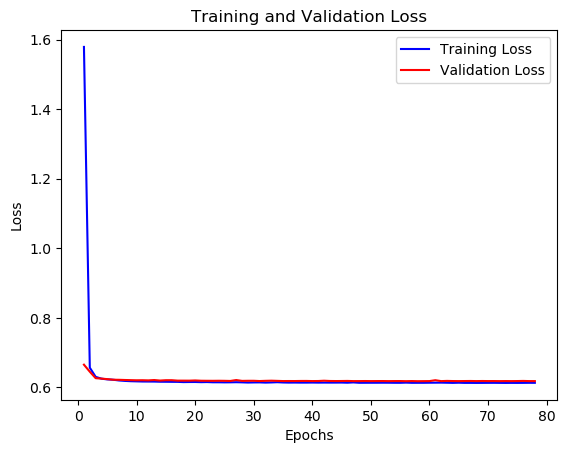

In [17]:

# Get the training and validation loss values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [18]:
model_version = 'NewAutoencoderModel14'
print(model_version)

NewAutoencoderModel14


In [19]:
ae.save(f"../../BottlesAnomalies_TFM/models/{model_version}")

2023-06-04 20:52:07.500526: W tensorflow/python/util/util.cc:329] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../../BottlesAnomalies_TFM/models/NewAutoencoderModel14/assets


In [20]:
print(type(ae))

<class 'tensorflow.python.keras.engine.training.Model'>


Loading the model that was previously saved


In [21]:
model = keras.models.load_model('../models/NewAutoencoderModel14')
print(type(model))

<class 'tensorflow.python.keras.engine.training.Model'>


## See the weights after the model loading

These are the weights of a specific layer of the encoder model, AFTER training:

In [22]:
layer_number = 1
print("quantity of layers in the model: ", len(encoder.layers))
print("The weigths in the", encoder.layers[layer_number].name, "is: ", encoder.layers[layer_number].weights)

quantity of layers in the model:  15
The weigths in the conv2d is:  [<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 128) dtype=float32, numpy=
array([[[[-0.197275  ,  0.02440149,  0.04268571, ..., -0.09936894,
          -0.07417551, -0.00042674],
         [-0.25009167, -0.01823772, -0.03613914, ..., -0.06036418,
          -0.03489982, -0.00711399],
         [-0.2525933 ,  0.02051373, -0.03699475, ..., -0.09181241,
          -0.07908922,  0.00759996]],

        [[ 0.15320937, -0.05416679, -0.08107466, ..., -0.07916218,
          -0.08466578, -0.0440409 ],
         [ 0.17455642, -0.00545059,  0.01789059, ...,  0.01929818,
          -0.07061579, -0.03125105],
         [ 0.14296342, -0.07148308, -0.085917  , ..., -0.06825492,
           0.01460432,  0.02830217]],

        [[-0.23188   ,  0.01863556,  0.00696882, ..., -0.10514954,
           0.00045203, -0.05557492],
         [-0.23760779, -0.05685296,  0.01175622, ..., -0.13549317,
          -0.07573577, -0.03164079],
         [-0.12706494

These are the weights of a specific layer of the Autoencoder model, AFTER training:

In [23]:
layer_number = 1
print("quantity of layers in the model: ", len(model.layers))
print("The weigths in the", model.layers[layer_number].name, "is: ", model.layers[layer_number].weights)

quantity of layers in the model:  16
The weigths in the conv2d is:  [<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 128) dtype=float32, numpy=
array([[[[-0.197275  ,  0.02440149,  0.04268571, ..., -0.09936894,
          -0.07417551, -0.00042674],
         [-0.25009167, -0.01823772, -0.03613914, ..., -0.06036418,
          -0.03489982, -0.00711399],
         [-0.2525933 ,  0.02051373, -0.03699475, ..., -0.09181241,
          -0.07908922,  0.00759996]],

        [[ 0.15320937, -0.05416679, -0.08107466, ..., -0.07916218,
          -0.08466578, -0.0440409 ],
         [ 0.17455642, -0.00545059,  0.01789059, ...,  0.01929818,
          -0.07061579, -0.03125105],
         [ 0.14296342, -0.07148308, -0.085917  , ..., -0.06825492,
           0.01460432,  0.02830217]],

        [[-0.23188   ,  0.01863556,  0.00696882, ..., -0.10514954,
           0.00045203, -0.05557492],
         [-0.23760779, -0.05685296,  0.01175622, ..., -0.13549317,
          -0.07573577, -0.03164079],
         [-0.12706494

Indeed the weights of the "Autoencoder" model have been updated but the ones from the "Encoder" have not. This is expected, since the model that was trained was actually the "Autoencoder" mdoel.

## Perform an Autoencoder reconstruction in one image

Get all batches generated by the datagen and pick a batch for prediction

In [24]:
#Just to test the model. 
data_batch = []  #Capture all training batches as a numpy array
img_num = 0
# while img_num <= train_generator.batch_index:   #gets each generated batch of size batch_size
while img_num < len(original_generator):        #I think this should be the correct while clause
    data = original_generator.next()
    data_batch.append(data[0])
    img_num = img_num + 1
    
print("number of batches are: ", img_num)


number of batches are:  12


In [25]:
print(len(data_batch))

12


Predict on the first batch of images. Do also notice that the prediction is being carried out over the images we used for training.

In [26]:
print(data_batch[0].shape)
predicted = model.predict(data_batch[0])  
print(predicted.shape)

(15, 224, 224, 3)
(15, 224, 224, 3)


The above is 15 length because it corresponds to the 15 predicted images of a batch. Recall that the predictions are reconstructions of the input images, since we are working with the autoencoder network.

In [27]:
single_img = data_batch[0][0]

In [28]:
print(single_img.shape)

(224, 224, 3)


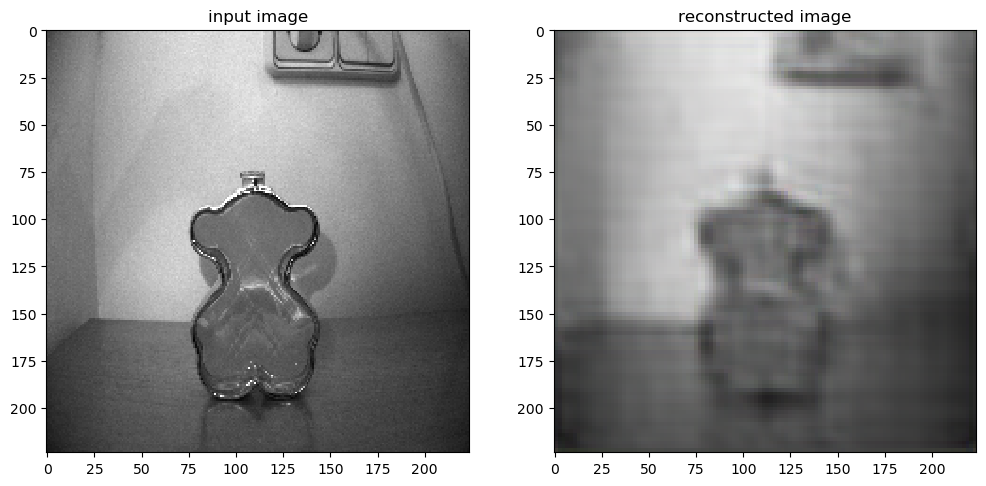

In [29]:
#Sanity check, view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0]-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("input image")
plt.imshow(data_batch[0][image_number])
plt.subplot(122)
plt.title("reconstructed image")
plt.imshow(predicted[image_number])
plt.show()

# Quantifying the reconstruction error using "evaluate_generator()" function

Let us examine the reconstruction error of our validation data (good/normal images) and the anomaly images

In [30]:
validation_error = model.evaluate_generator(validation_generator)
print("Recon. error for the validation (normal) data is: ", validation_error)

Instructions for updating:
Please use Model.evaluate, which supports generators.
Recon. error for the validation (normal) data is:  0.6178699731826782


This reconstruction error above should be very low, since the validation generator is full of normal images (good images)

Whereas the reconstruction error here below, for the "anomaly_generator" should be higher, since this dataset is comprised of full anomaly images.

In [31]:
anomaly_error = model.evaluate_generator(anomaly_generator)
print("Recon. error for the anomaly data is: ", anomaly_error)

Recon. error for the anomaly data is:  0.607319712638855


See that this error is slightly higher than the error in the validation dataset. This is good, but the difference is not that significant and this could result in wrong anomaly detections. Let's see some detections.

SIDENOTE: Additionally, we can check the train generator error according to the "evaluate_generator()" function.

In [32]:
training_error = model.evaluate_generator(original_generator)
print("Recon. error for the training (non-anomaly) data is: ", training_error)

Recon. error for the training (non-anomaly) data is:  0.6122493147850037


See that the above value does not correspond with the below mean reconstruction error of the training set that will be computed. It should at least be close, I think. This is something to check.

Also see tha the error from the anomaly images is smaller than the error of the training set, which consists of non-anomaly images. THis is not expected and means that this particular model is shit.

# Computing the reconstruction error without using the "evaluate_generator()" function

The following function computes the reconstrution error per each batch of images. It does, for each of the batches:
- Initialize a vector for storing the reconstruction errors.
- A for loop that traverses all the images contained in a batch.
    - Take the one image of the batch.
    - Add a new size dimension to the image.
    - Make a prediction of the selected image with the model that was built.
    - Evaluate the performance of the prediction, i.e. compute the prediction error.
    - Append the reconstruction error into a list.
- Compute the mean and std deviation of the error.
 

In [33]:
def calc_recon_error(batch_images):   
    recon_error_list=[]
    for im in range(0, batch_images.shape[0]):
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        reconstruction = model.predict([[img]])
        # reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]    # The batch_size parameter for the moment can be supressed. Results were seen to be the same
        # reconstruction_error = model.evaluate([reconstruction],[[img]])[0]                    # It included the [0] subscription but with this new model, the rec error is directly a float value, so no more need for subscription
        reconstruction_error = model.evaluate([reconstruction],[[img]])
        recon_error_list.append(reconstruction_error)   
    return recon_error_list

In [34]:
total_rec_error = []
for i in range(len(original_generator)):        #I think this should be the correct while clause
    data = original_generator.next()
    total_rec_error.append(calc_recon_error(data[0]))
    
print("The list of rec. error contains ", len(total_rec_error), "batches of rec. errors")

1/1 [==============================] - 0s 835us/step - loss: 0.5893
The list of rec. error contains  12 batches of rec. errors


In [35]:
total_rec_error_list = [item for sublist in total_rec_error for item in sublist]
print(len(total_rec_error_list))

179


In [36]:
na_average_recon_error = np.mean(np.array(total_rec_error_list))  
na_stdev_recon_error = np.std(np.array(total_rec_error_list)) 
min_prob = np.min(total_rec_error_list)
max_prob = np.max(total_rec_error_list)
print("THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES\n")
print("The average of the errors list is: ", na_average_recon_error)
print("The standard deviation of the errors list is: ", na_stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES

The average of the errors list is:  0.6174156209610028
The standard deviation of the errors list is:  0.012129855403111272
The min value of the errors list is:  0.5766909718513489
The max value of the errors list is:  0.632382869720459


Compute the average and std dev. of recon. error for positive (anomalies) samples. 


In [37]:
anomaly_batch = anomaly_generator.next()

In [38]:
total_rec_error_anomalies = []
for i in range(len(anomaly_generator)):        #I think this should be the correct while clause
    data = anomaly_generator.next()
    total_rec_error_anomalies.append(calc_recon_error(data[0]))
    
print("The list of rec. error for anomalies contains ", len(total_rec_error_anomalies), "batches of rec. errors")

1/1 [==============================] - 0s 923us/step - loss: 0.6087
The list of rec. error for anomalies contains  1 batches of rec. errors


In [39]:
total_rec_error_anomalies = [item for sublist in total_rec_error_anomalies for item in sublist]
print(len(total_rec_error_anomalies))

6


In [40]:
a_average_recon_error = np.mean(np.array(total_rec_error_anomalies))  
a_stdev_recon_error = np.std(np.array(total_rec_error_anomalies)) 
min_prob = np.min(total_rec_error_anomalies)
max_prob = np.max(total_rec_error_anomalies)
print("THIS IS FOR THE ANOMALY IMAGES\n")
print("The average of the errors list is: ", a_average_recon_error)
print("The standard deviation of the errors list is: ", a_stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE ANOMALY IMAGES

The average of the errors list is:  0.6139115691184998
The standard deviation of the errors list is:  0.01581223050028573
The min value of the errors list is:  0.5808173418045044
The max value of the errors list is:  0.6253805160522461


Compute the average and std dev. of recon. error for the validation (non-anomalies) samples. 


In [41]:
total_rec_error_validation = []
for i in range(len(validation_generator)):        #I think this should be the correct while clause
    data = validation_generator.next()
    total_rec_error_validation.append(calc_recon_error(data[0]))
    
print("The list of rec. error for anomalies contains ", len(total_rec_error_validation), "batches of rec. errors")

1/1 [==============================] - 0s 661us/step - loss: 0.6260
The list of rec. error for anomalies contains  2 batches of rec. errors


In [42]:
total_rec_error_validation = [item for sublist in total_rec_error_validation for item in sublist]
print(len(total_rec_error_validation))

30


In [43]:
val_average_recon_error = np.mean(np.array(total_rec_error_validation))  
val_stdev_recon_error = np.std(np.array(total_rec_error_validation)) 
min_prob = np.min(total_rec_error_validation)
max_prob = np.max(total_rec_error_validation)
print("THIS IS FOR THE VALIDATION IMAGES\n")
print("The average of the errors list is: ", val_average_recon_error)
print("The standard deviation of the errors list is: ", val_stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE VALIDATION IMAGES

The average of the errors list is:  0.6239988545576731
The standard deviation of the errors list is:  0.0017756982699994731
The min value of the errors list is:  0.6212786436080933
The max value of the errors list is:  0.6272616982460022


Below, we can see the plot of the reconstruction error values, of the non-anomaly list (blue) and the anomaly list (red).

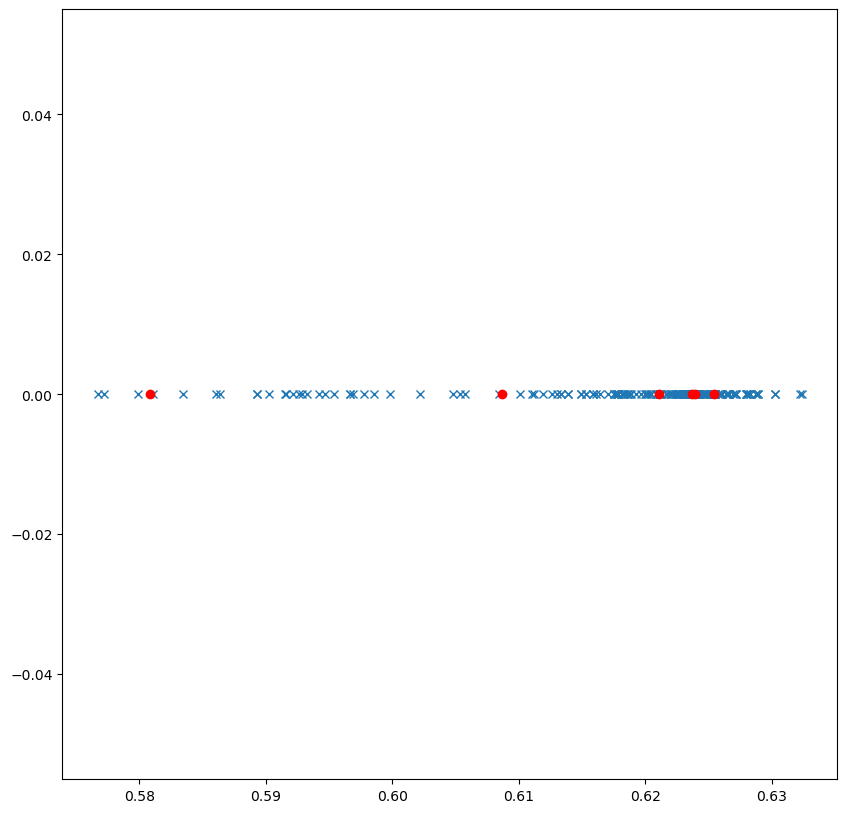

In [44]:
plt.figure(figsize=(10, 10))
val = 0. # this is the value where you want the data to appear on the y-axis.
plt.plot(total_rec_error_list, np.zeros_like(total_rec_error_list) + val, 'x')
plt.plot(total_rec_error_anomalies, np.zeros_like(total_rec_error_anomalies) + val, 'ro')
plt.show()

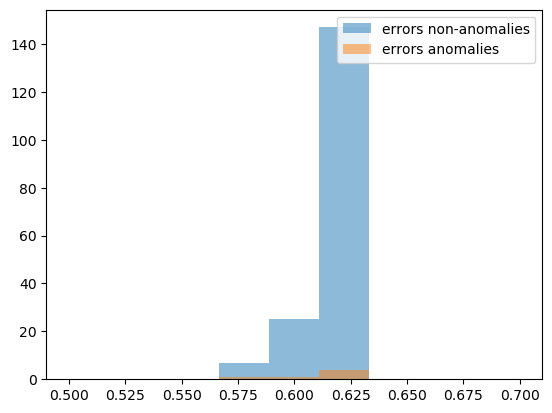

In [46]:
import random
import numpy
from matplotlib import pyplot

bins = numpy.linspace(0.5, 0.7, 10)

pyplot.hist(total_rec_error_list, bins, alpha=0.5, label='errors non-anomalies')
pyplot.hist(total_rec_error_anomalies, bins, alpha=0.5, label='errors anomalies')
pyplot.legend(loc='upper right')
pyplot.show()

## Checking the latent space

Let's update the weights of the encoder model.

In [47]:
# Copy the layer weights from the base model to the target model
for i, target_layer in enumerate(encoder.layers):
    base_layer = model.layers[i]
    target_layer.set_weights(base_layer.get_weights())

# Verify if the weights are successfully copied
for base_layer, target_layer in zip(model.layers[:len(encoder.layers)], encoder.layers):
    base_weights = base_layer.get_weights()
    target_weights = target_layer.get_weights()
    for base_weight, target_weight in zip(base_weights, target_weights):
        if (base_weight == target_weight).all():
            print("Layer weights are successfully copied.")
        else:
            print("Error: Layer weights are not copied correctly.")


Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.


In [48]:
########################################################
# Calculate KDE using sklearn
from sklearn.neighbors import KernelDensity

#Get encoded output of input images = Latent space
encoded_images = encoder.predict_generator(original_generator)

Instructions for updating:
Please use Model.predict, which supports generators.


In [49]:
print(encoded_images.shape)

(179, 32)


See that it is 179 length because it corresponds to all the images that belong to the training dataset. The second length corresponds to the output shape of the model as specified in its structure at the beginning.

In [50]:
type(encoded_images)

numpy.ndarray

In [51]:
encoder_output_shape = encoder.output_shape 
print(encoder_output_shape)

(None, 32)


Now, let's fit KDE to the image latent data

In [52]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images)

The above function fits a kernel density estimation to the data that is provided, that is, the "encoded_images" variable. It does so using a Guassian kernel of bandwidth 0.2.

The badnwidth parameter affects on how the selected kernel will fit each sample of the given data. For example for the case in which the kernel is a Gaussian distribution, the bandwidth parameter would affect in how thin or wide is the Gaussian distribution.

At this point in the variable "kde" we have some numbers that are the result of fitting Gaussian functions to the given data points in the variable "encoded_images". We will use the "kde" variable later for scoring with it, some given data points; the scoring will be given depending on how similar are the given data points to the ones that it had estimated.

Here below, it is shown the kde values corresponding to each encoded sample. THese are supposed to be very close to each other in value.

In [53]:
density_vals = kde.score_samples(encoded_images)
print(density_vals)

[17.00070202 17.81931699 17.45190293 17.6377479  18.14926795 17.68336389
 18.12625574 18.10602958 18.27674471 18.29256411 18.120399   18.29617489
 17.98991801 17.95134223 17.71877363 17.57134103 18.08443719 17.5887993
 17.26124356 17.32426967 18.12817682 18.21666397 18.61553936 18.17042535
 18.72733843 17.02021422 17.70088726 17.59245459 18.1436236  18.47546001
 17.63272241 17.94316279 18.36248011 18.32365121 18.06365795 18.35029795
 18.61311381 18.62157494 18.44561057 18.29647686 17.36734159 17.62702503
 18.88197602 18.84502663 18.33754175 18.5124308  18.53806822 18.6645636
 18.64123226 18.61384276 18.52076816 17.2568103  17.38854315 17.75035365
 17.4618469  18.41428896 18.88026949 18.87374409 18.83637424 18.85633621
 17.60942616 17.76037197 18.27062103 19.0654283  19.11943779 19.08830565
 18.90551846 18.93042348 18.99014911 17.99081706 18.19357369 18.12171171
 17.85355529 17.85697574 18.97303243 19.01338931 19.07510166 19.02333916
 18.89475981 17.87532905 17.60942616 17.76037197 18.2

From here, the mean and standard deviation of these values are computed

In [54]:
average_density = np.mean(density_vals)
stdev_density = np.std(density_vals)
print("The avg of the density values is: ", average_density)
print("The stdev_density of the density values is: ", stdev_density)

The avg of the density values is:  18.347901291824805
The stdev_density of the density values is:  0.6489021216739866


based on the above data create a function that outputs a probability of a KDE value to be considered an anomaly or non-anomaly image

In [55]:
def ranges_mapper(value, leftMin, leftMax, rightMin, rightMax):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)

In [56]:
def map_kde2prob_list(input_list):
    threshold = average_density          # The mean of the kde corresponding to the non-anomaly images
    std_dev = stdev_density            # The std deviation of the kde corresponding to the non-anomaly images
    prob_score_list = []
    prob_score = 0              # This was changed for making threshold+std_dev be mapped to be 50% chance. Before it was directly mapped threshold value to 50% chance
    for i in range (len(input_list)):
        aux_score = input_list[i] - threshold
        if aux_score>=0:
            additional = ranges_mapper(aux_score, 0, std_dev, 0, 50)
            prob_score_tot = prob_score+additional
        else:
            additional = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
            prob_score_tot = prob_score-additional
        if prob_score_tot > 100:
            prob_score_tot = 100
        if prob_score_tot < 0:
            prob_score_tot = 0
        prob_score_list.append(prob_score_tot)
    return prob_score_list

In [57]:
def map_kde2prob(value):
    threshold = average_density         # The mean of the kde corresponding to the non-anomaly images
    std_dev = stdev_density          # The std deviation of the kde corresponding to the non-anomaly images
    prob_score = 0              # This was changed for making threshold+std_dev be mapped to be 50% chance. Before it was directly mapped threshold value to 50% chance
    aux_score = value - threshold
    print("value is: ", value)
    print("aux_score is: ", aux_score)
        
    if aux_score>=0:
        additional = ranges_mapper(aux_score, 0, std_dev, 0, 50)
        print("additional is: ", additional)
        prob_score_tot = prob_score+additional
        print("prob_score_tot is: ", prob_score_tot)
        
    else:
        additional = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
        prob_score_tot = prob_score-additional
    if prob_score_tot > 100:
        prob_score_tot = 100
    if prob_score_tot < 0:
        prob_score_tot = 0    
    return prob_score_tot

In [58]:
def computePred(kde_value):
    pred = 0
    prob_anomaly = map_kde2prob(kde_value)/100
    if prob_anomaly > 0.5:
        pred = 1
    return pred

In [59]:
print(map_kde2prob_list([average_density + stdev_density+0.00000000000000168]))

[50.000000000000085]


In [60]:
#Get encoded output of input images = Latent space
encoded_images_test_set = encoder.predict_generator(test_set_generator)

In [61]:
print(encoded_images_test_set.shape)

(30, 32)


In [62]:
density_vals_test = kde.score_samples(encoded_images_test_set)
print(density_vals_test)

[17.35347218 17.50255642 16.23448466 16.22842259 16.28895873 15.64360609
 15.88942223 16.30636788 17.03015068 16.55856836 17.43684909 17.5228905
 17.63680939 17.56364784 16.5567895  17.67393657 17.32786804 16.60852709
 16.90307252 16.62028502 16.30800783 15.62847909 14.42895806 14.15180574
 15.91688292 15.61715216 15.3772358  14.92549597 15.68595121 16.11624168]


In [63]:
average_density + stdev_density

18.996803413498792

In [64]:
prob_test = map_kde2prob_list(density_vals_test)
print(prob_test)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


See the final predictions based on the KDE average values that was computed before.

In [65]:
ground_truth = []
for i in range(len(test_set_generator)):        #I think this should be the correct while clause
    _, labels = test_set_generator.next()
    ground_truth.append(labels)
    
print("The list of rec. error for anomalies contains ", len(ground_truth), "batches of rec. errors")

The list of rec. error for anomalies contains  2 batches of rec. errors


In [66]:
ground_truth = [item for sublist in ground_truth for item in sublist]
ground_truth = [int(x) for x in ground_truth]


In [67]:
pred_list =[]
for i in range(len(prob_test)):
    
    if(prob_test[i]>50):
        pred = 1
    else:
        pred = 0
    pred_list.append(pred)
print(ground_truth)
print(pred_list)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
